# Оглавление
- [Описание проекта](##Описание_проекта)
- [План работы](##План_работы)
- [Загрузка данных](##Загрузка_данных)
- [Предобработка данных](##Предобработка_данных)
- [Испытание моделей](##Испытание_моделей)
- [Итоговая модель](##Итоговая_модель)
- [Анализ итоговой модели](##Анализ_итоговой_модели)
- [Выводы](##Выводы)
- [Список используемой литературы](##Список_используемой_литературы)

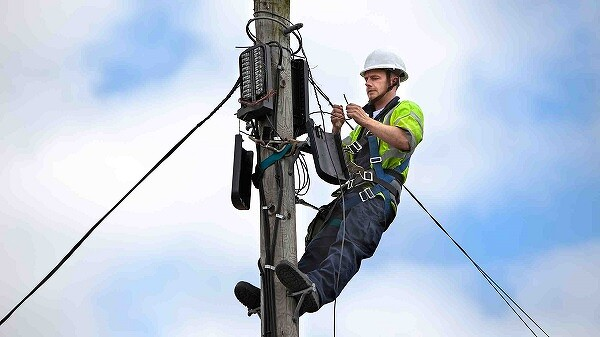

## Описание проекта


Оператор связи "Ниединогоразрыва.ком" хочет разработать модель прогнозирования оттока клиентов. Целью является выявление пользователей, которые планируют прекратить пользоваться услугами оператора, чтобы им предложить специальные условия и промокоды. Команда оператора собрала данные о клиентах, включая персональную информацию, информацию о тарифах и договорах.

Оператор предоставляет два основных типа услуг: стационарную телефонную связь и интернет. Интернет может быть предоставлен через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic). Кроме того, доступны дополнительные услуги, такие как антивирус и блокировка небезопасных сайтов, выделенная линия технической поддержки, облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

Клиенты могут платить за услуги ежемесячно или заключить договор на 1-2 года. Также доступны различные способы расчета и возможность получения электронного чека.

## План работы 

Первой задачей будет то, что данные нужно загрузить и просмотреть на корректность.

Далее необходимо изучить их на аномалии или пропущенные данные. При необходимости обработать доступными средствами.

Далее можно будет приступить к испытанию моделей и проверке их качества на метрике ROC-AUC. Целевым качеством будет считаться не менее 85.
Для исследовательского подхода буду применять 3 модели - линейную регрессию, случайный лес и кэтбуст.


После этого будет возможным изучить важность признаков модели, их предобработки для дальнейшего анализа оттока клиентов  

## Загрузка данных

In [1]:
#КОД ТИМЛИДА

!pip install imblearn

In [2]:
!pip install phik

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

# Установка стиля графиков seaborn
sns.set_style("whitegrid")



In [4]:
pd.set_option('display.max_columns', None)

In [5]:
RANDOM_STATE = 220523

In [6]:
try:
    contract_path = 'https://code.s3.yandex.net/datasets/contract_new.csv'
    personal_path = 'https://code.s3.yandex.net/datasets/personal_new.csv'
    internet_path = 'https://code.s3.yandex.net/datasets/internet_new.csv'
    phone_path = 'https://code.s3.yandex.net/datasets/phone_new.csv'
except Exception:
    print('ну я не знаю где они лежат____'*100)
    

In [7]:
def download(path):
    name = path.split('/')[-1].split('.')[0]
    data = pd.read_csv(path)
    return name, data

In [8]:
def convert_to_snake_case(column_name):
    snake_case = ""
    for char in column_name:
        if char.isupper():
            snake_case += "_" + char.lower()
        else:
            snake_case += char
    if snake_case.startswith("_"):
        snake_case = snake_case[1:]
    return snake_case

In [9]:
contract_name, contract_data = download(contract_path)
personal_name, personal_data = download(personal_path)
internet_name, internet_data = download(internet_path)
phone_name, phone_data = download(phone_path)
all_data = [(contract_name, contract_data), (personal_name, personal_data), (internet_name, internet_data), (phone_name, phone_data)]

In [10]:
for i, (data_name, data) in enumerate(all_data):
    print(f"Table {i+1}: {data_name}")
    display(data)
    print('\n')

Table 1: contract_new


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8




Table 2: personal_new


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No




Table 3: internet_new


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No




Table 4: phone_new


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Все загруженные данные имеют корректный вид, представляют из себя строки и колонки. Как и было упомянуто в изначальном задании -  у всех есть общий признак customerID. 

Все дополнительные услуги и признаки, которые маркеруются как yes и no на этапе предообработки перекодирую с помощью OHE.



По нему предполагаю сделать объединение в одну таблицу и работать уже с ней.  

### Объединение таблиц

In [11]:
total_data = pd.merge(personal_data, contract_data, on='customerID', how='left')
total_data = pd.merge(total_data, internet_data, on='customerID', how='left')
total_data = pd.merge(total_data, phone_data, on='customerID', how='left')

In [12]:
print("Итоговый датасет:")
display(total_data)

Итоговый датасет:


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,Fiber optic,No,No,No,No,No,No,Yes


In [13]:
column_mapping = {name: convert_to_snake_case(name) for name in total_data.columns}
total_data = total_data.rename(columns=column_mapping)
total_data = total_data.rename(columns={'customer_i_d': 'customer_id'})
print(total_data.columns)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')


Изначально не нашел целевой признак, посчитал, что в колонке окончания договора будет стоять признак yes, но оказалось, что в этой колонке будет дата окончания договора.
В будущем считаю возможным из этих двух признаков сделать один - числовое значение количества дней присутствия клиента в договорных отношениях. 
Также те клиенты, у кого договор действителен будут считаться таковыми до условной границы нашего исследования - до 1 февраля 2020 года.

Ушедшие клиенты станут целевым признаком и по ним будет обучаться модель.

In [14]:
filtered_data = total_data[total_data['end_date'] == 'Yes']
print(filtered_data)
unique_types = total_data['end_date'].unique()
print(unique_types)

Empty DataFrame
Columns: [customer_id, gender, senior_citizen, partner, dependents, begin_date, end_date, type, paperless_billing, payment_method, monthly_charges, total_charges, internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v, streaming_movies, multiple_lines]
Index: []
['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' 

### Пропуски

посмотрим на доли пропусков в том или ином признаке

In [15]:
missing_percent = total_data.isnull().sum() / len(total_data) * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)
print("Доля пропусков во всем датасете:")
print(missing_percent_sorted)

Доля пропусков во всем датасете:
streaming_movies     21.666903
streaming_t_v        21.666903
tech_support         21.666903
device_protection    21.666903
online_backup        21.666903
online_security      21.666903
internet_service     21.666903
multiple_lines        9.683374
gender                0.000000
total_charges         0.000000
customer_id           0.000000
payment_method        0.000000
paperless_billing     0.000000
type                  0.000000
end_date              0.000000
begin_date            0.000000
dependents            0.000000
partner               0.000000
senior_citizen        0.000000
monthly_charges       0.000000
dtype: float64


In [16]:
unique_types = total_data['type'].unique()
print(unique_types)

value_counts = total_data['type'].value_counts()
value_counts_percent = value_counts / len(total_data) * 100
print(value_counts_percent)


['Month-to-month' 'One year' 'Two year']
type
Month-to-month    55.019168
Two year          24.066449
One year          20.914383
Name: count, dtype: float64


In [17]:
unique_types = total_data['payment_method'].unique()
print(unique_types)

value_counts = total_data['payment_method'].value_counts()
value_counts_percent = value_counts / len(total_data) * 100
print(value_counts_percent)


['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
payment_method
Electronic check             33.579441
Mailed check                 22.887974
Bank transfer (automatic)    21.922476
Credit card (automatic)      21.610109
Name: count, dtype: float64


In [18]:
unique_types = total_data['internet_service'].unique()
print(unique_types)

value_counts = total_data['internet_service'].value_counts(dropna=False)
value_counts_percent = value_counts / len(total_data) * 100
print(value_counts_percent)

['DSL' 'Fiber optic' nan]
internet_service
Fiber optic    43.958540
DSL            34.374556
NaN            21.666903
Name: count, dtype: float64


In [19]:
unique_types = total_data['dependents'].unique()
print(unique_types)

value_counts = total_data['dependents'].value_counts()
value_counts_percent = value_counts / len(total_data) * 100
print(value_counts_percent)

['No' 'Yes']
dependents
No     70.041176
Yes    29.958824
Name: count, dtype: float64


### Числовой признак

Другой важный признак, как я считаю, будет объем оплаты услуг

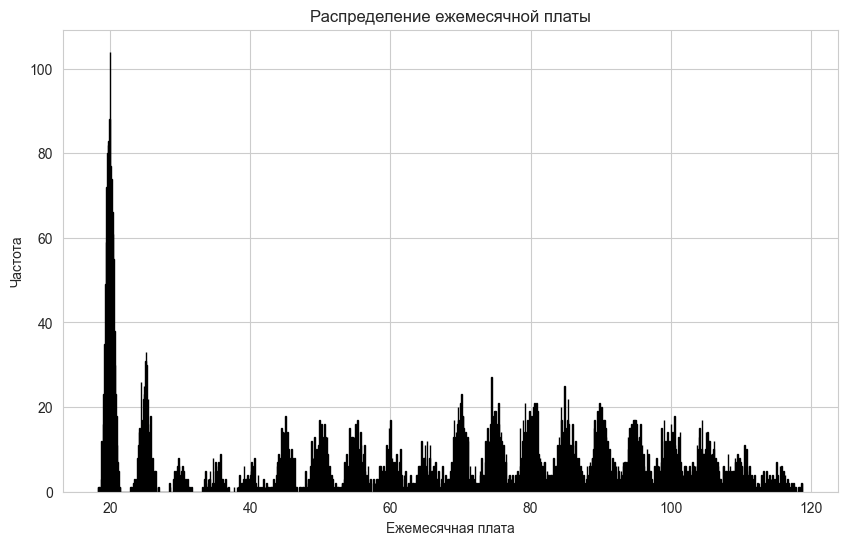

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(total_data['monthly_charges'], bins=1000, edgecolor='black')

plt.title('Распределение ежемесячной платы')
plt.xlabel('Ежемесячная плата')
plt.ylabel('Частота')
plt.show()

In [21]:
total_data_temp = total_data.copy()
total_data_temp['total_charges'] = pd.to_numeric(total_data_temp['total_charges'], errors='coerce')
total_data_temp['total_charges_group'] = pd.cut(total_data_temp['total_charges'], bins=30, include_lowest=False, right=False, precision=1)

grouped_data = total_data_temp.groupby('total_charges_group').size().reset_index(name='Count')
print(grouped_data.head(2))

value_counts = total_data_temp['total_charges_group'].value_counts(dropna=False)
value_counts_percent = value_counts / len(total_data) * 100
#print(value_counts_percent)

  total_charges_group  Count
0       [19.0, 325.8)   1386
1      [325.8, 632.5)    844


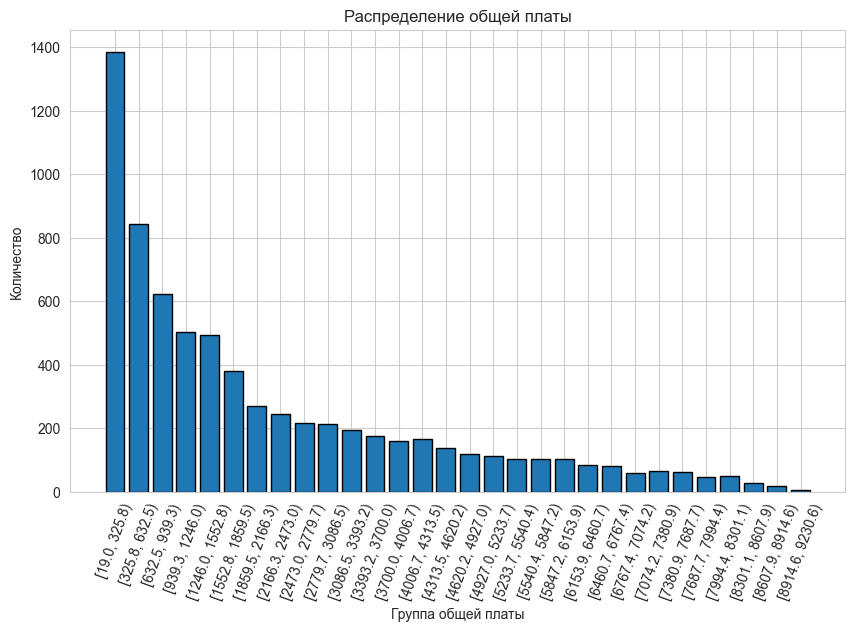

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(grouped_data)), grouped_data['Count'], edgecolor='black')

plt.title('Распределение общей платы')
plt.xlabel('Группа общей платы')
plt.ylabel('Количество')
plt.xticks(range(len(grouped_data)), grouped_data['total_charges_group'], rotation=70)
plt.show()

в месячных платежах есть очень большой пик у околонулевых значений, возможно, что эти клиенты выбирают дешевые услуги или не выбирают их совсем и также не остаются на длинную дистанцию с поставщиком услуг. 
Возможно, что признаки из таблицы internet_new не окажут необходимого действия, но это покажет иследование.

### Вопросы

Насколько я понимаю в этом заключался первый этап работы - поверхностное изучение без предобработки.

По сему имею несколько вопросов 

- я не заметил острой необходимости в глубокой предобработке. Пропущенные данные приходят из добавленных таблиц phone_new и internet_new. Корректно ли будет заменить пропуски на no и работать с этим дальше?

- можно посчитать неважными многие признаки и оставить лишь минимальный набор, но насколько я понимаю - мало данных не бывает - поэтому правильно ли я поступлю, если оставлю все что есть?

- будет создан дополнительный признак - факт оттока - и он станет целевым. Норм?



## Предобработка данных

Первым шагом сделаю изменение и удаление признаков. Колонки с датами переделаю в длительность периода контракта, а но основании факта ухода сделаю целевой признак. Ушедшие клиенты станут маркером для модели и помогут избежать утечки клиентов в будущем.

Также около половины данных это подключенные или непредоставленные услуги. Они будут составлять трудность при определении модели, и их придется кодировать

In [23]:
total_data['target'] = total_data['end_date'].apply(lambda x: 0 if x == 'No' else 1)

total_data['end_date'] = total_data['end_date'].replace('No', '2020-02-01')

total_data['duration'] = (pd.to_datetime(total_data['end_date']) - pd.to_datetime(total_data['begin_date'])).dt.days

total_data.drop(['begin_date', 'end_date'], axis=1, inplace=True)

In [24]:
total_data.target.unique()

array([0, 1], dtype=int64)

Пропущенные значения из таблицы internen, personal заменю на No

In [25]:
categorical_columns = [column for column in total_data.columns if total_data[column].isnull().any()]
total_data[categorical_columns] = total_data[categorical_columns].fillna('No')
total_data.head()

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target,duration
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No,0,153


In [26]:
total_data['senior_citizen'] = total_data['senior_citizen'].replace('No', 0)

In [27]:
total_data = total_data.drop(['customer_id', 'paperless_billing'], axis=1)


interval columns not set, guessing: ['senior_citizen', 'target', 'duration']


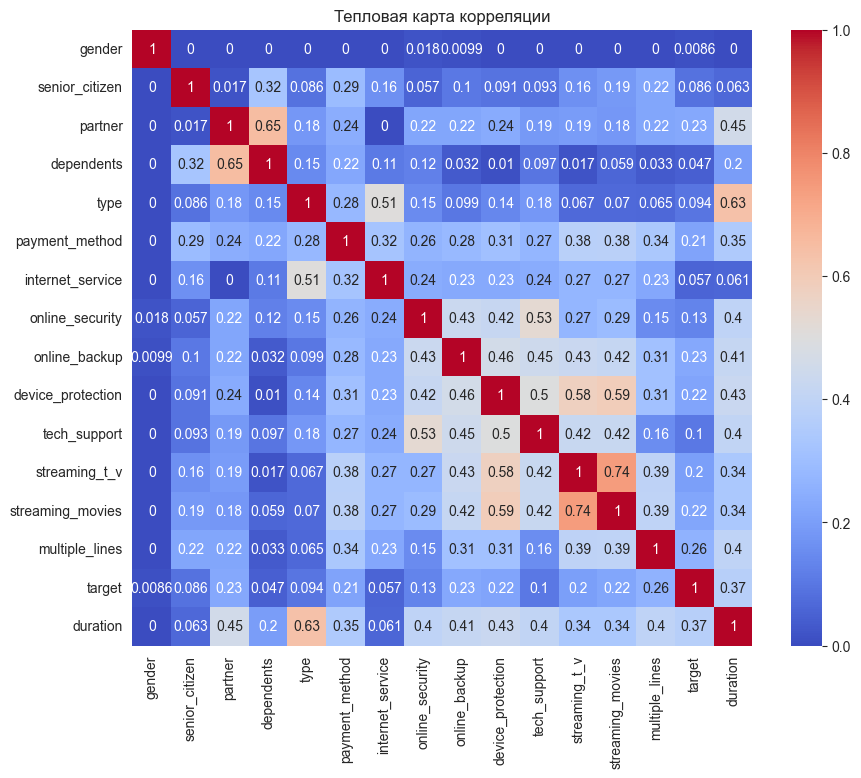

In [28]:
data_for_correlation = total_data.drop(columns=['total_charges', 'monthly_charges'])

correlation_matrix = data_for_correlation.phik_matrix()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()


При беглом осмотре можно увидеть, что есть устойчивые корреляции, но насколько можно судить - они предсказуемы. Например, что при супружеских отношениях есть иждивенцы. Или что при подключенной услуге онлайн безопасности есть услуга тех.поддержки. Добавленный признак длительности контракта имеет корреляцию с многими признаками. Можно сделать вывод, что признак полезный.
Также видно, что признак пола совсем не коррелирует и будет признан лишним и удален.

In [29]:
total_data = total_data.drop('gender', axis=1)

In [30]:
# Замена  тип данных float
total_data['total_charges'] = pd.to_numeric(total_data['total_charges'],errors='coerce')

#Заполнение ппропущеных строк Total Charges
total_data['total_charges'] = np.where(total_data['total_charges'].isna() , 0, total_data['total_charges'])


## Разделение на выборки

Разел моделирования начнем с простых моделей с RandomForest и LogisticRegression. Для них приведем разделение на выборки и кодирование с помощью OHE. 

In [31]:
features =total_data.drop(['target'], axis=1)
target = total_data['target']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)


In [32]:
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

#категориальные признаки для OHE RandomForestRegressor
ohe_features_rf = ohe_features.copy()

ohe_features_rf

['partner', 'dependents', 'type', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']


['partner',
 'dependents',
 'type',
 'payment_method',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies',
 'multiple_lines']

In [33]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('senior_citizen')
num_features

['monthly_charges', 'total_charges', 'duration']

In [34]:
X_train_ohe = X_train.copy()

In [35]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_ohe[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ohe[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ohe = X_train_ohe.drop(ohe_features, axis=1)

X_train_scaler = X_train_ohe.copy()

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_scaler[num_features] = scaler.fit_transform(X_train_scaler[num_features])

# смотрим на результат
X_train_scaler.head()

,senior_citizen,monthly_charges,total_charges,duration,partner_Yes,dependents_Yes,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_t_v_Yes,streaming_movies_Yes,multiple_lines_Yes
5450,0,0.664236,-0.928711,-1.235291,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6056,0,0.213546,0.972769,1.260148,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4612,0,-0.646258,0.390396,1.570432,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
43,0,0.504582,1.384645,1.481152,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
6860,0,1.237992,-0.060293,-0.481537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


## Logistic Regression


In [36]:
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
parameters = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200],
    'class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(model, parameters, scoring='roc_auc', cv=5)

In [37]:
# Подбор гиперпараметров с использованием кросс-валидации
grid_search.fit(X_train_scaler, y_train)
train_roc_auc_lr_cv = grid_search.best_score_

In [38]:

best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC AUC Score: 0.7650803388239994


## Random Forest

модель явно переобученная, попробую сделать через GS

In [39]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='roc_auc', cv=5)

In [40]:
grid_search.fit(X_train_ohe, y_train)
best_model = grid_search.best_estimator_

In [41]:
best_model = grid_search.best_estimator_
train_roc_auc_rf_cv = grid_search.best_score_
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best ROC AUC Score: 0.8283330660977188


здесь модель работает совершенно случайно, боюсь, что это связано с моей ошибкой

обучить модель хорошо  не получилось

## Cat Boost Classifier

In [74]:
categorical_columns = ['senior_citizen', 'partner', 'dependents', 'type', 'payment_method',
       'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines']

model_cb = CatBoostClassifier(cat_features=categorical_columns, random_state=RANDOM_STATE,verbose=False)


param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.1, 0.01],
    'depth': [5, 10],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search_cb = GridSearchCV(estimator=model_cb, param_grid=param_grid, scoring='roc_auc', cv=3)

In [75]:
grid_search_cb.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021186654A50>,
             param_grid={'depth': [5, 10], 'iterations': [100, 200],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.01]},
             scoring='roc_auc')

In [76]:
best_model_cb = grid_search_cb.best_estimator_
train_roc_auc_cb = grid_search_cb.best_score_
print("Best Parameters:", grid_search_cb.best_params_)
print("Best ROC AUC Score:", grid_search_cb.best_score_)

Best Parameters: {'depth': 5, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best ROC AUC Score: 0.8694882218746937


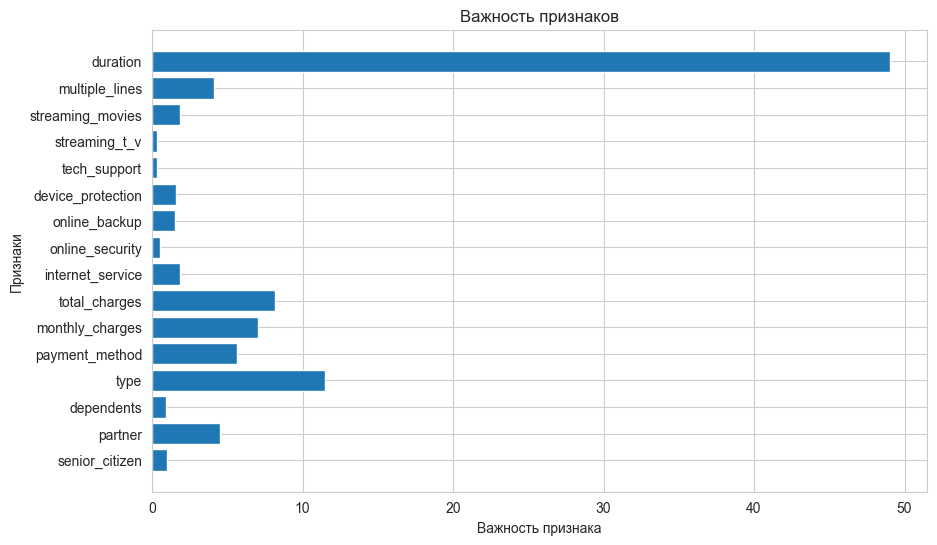

In [58]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков')

plt.show()

## LightGBM

In [59]:
encoded_features_train = X_train.copy()


for column in categorical_columns:
    encoded_features_train[column] = encoded_features_train[column].astype('category')
   

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
grid_search_gbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring='roc_auc', cv=3)



In [60]:
grid_search_gbm.fit(encoded_features_train, y_train)

best_params = grid_search_gbm.best_params_

In [83]:
best_model_gbm = grid_search_gbm.best_estimator_
train_roc_auc_gbm = grid_search_gbm.best_score_
print("Best Parameters:", grid_search_gbm.best_params_)
print("Best ROC AUC Score:", grid_search_gbm.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best ROC AUC Score: 0.859133332711204


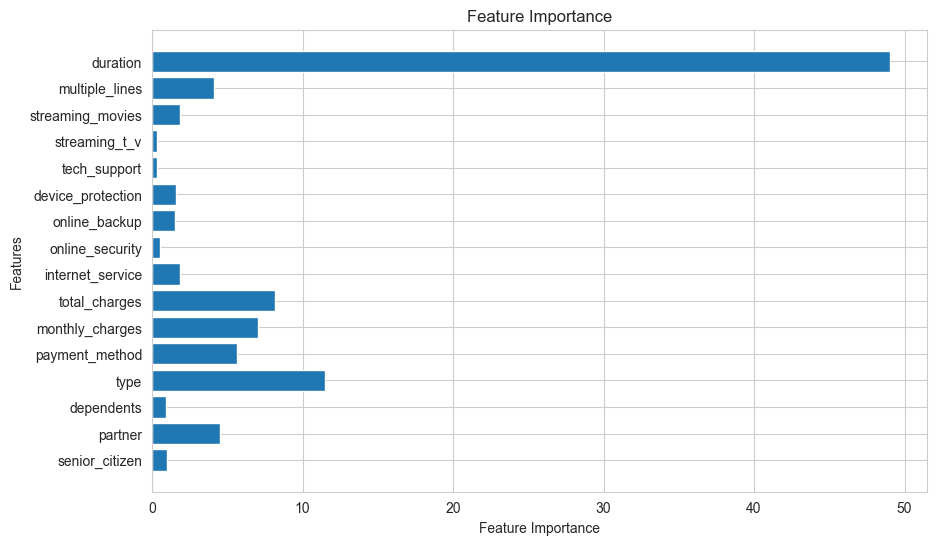

In [62]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_names = encoded_features_train.columns


plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')

plt.show()

In [77]:
metrics = {
    'Logistic Regression GS': {'Train ROC AUC': train_roc_auc_lr_cv},
    'Random Forest GS': {'Train ROC AUC': train_roc_auc_rf_cv},
    'Cat Boost': {'Train ROC AUC': train_roc_auc_cb},
    'LightGBM': {'Train ROC AUC': train_roc_auc_gbm}}


df = pd.DataFrame.from_dict(metrics, orient='index')


def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
df_styled = df.style.apply(highlight_max, subset=['Train ROC AUC'])


df_styled

,Train ROC AUC
Cat Boost,0.869488
LightGBM,0.859133
Logistic Regression GS,0.765080
Random Forest GS,0.828333


сделаю тест на лучшей модели 

In [88]:
y_pred = best_model_cb.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)

In [89]:
print("ROC AUC on validation set:", test_roc_auc)

ROC AUC on validation set: 0.6994689832374893


In [80]:
pred = best_model_cb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1486
           1       0.77      0.42      0.55       275

    accuracy                           0.89      1761
   macro avg       0.84      0.70      0.74      1761
weighted avg       0.88      0.89      0.88      1761



In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1452   34]
 [ 159  116]]

True Positives(TP) =  1452

True Negatives(TN) =  116

False Positives(FP) =  34

False Negatives(FN) =  159


<Axes: >

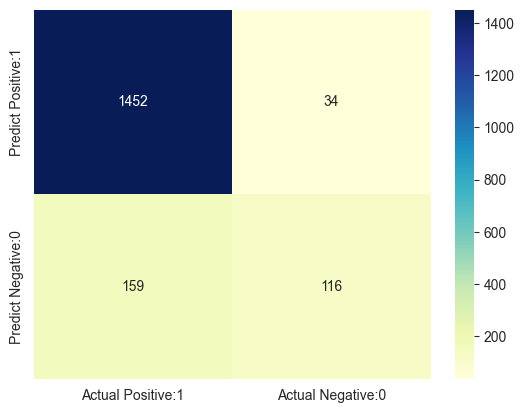

In [82]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Насколько понимаю, модель хорошо предсказывает какой клиент останется, но намного хуже, какой клиент уйдет. В контексте бизнеса, возможно, это будет равнозначным ответом, но мне бы хотелось, чтобы модель предсказывала достаточно точно оба варианта.

Отчет о проделенной работе:
Общие вводные
Оператор связи "Ниединогоразрыва.ком" хочет разработать модель прогнозирования оттока клиентов. Целью является выявление пользователей, которые планируют прекратить пользоваться услугами оператора, чтобы им предложить специальные условия и промокоды. Команда оператора собрала данные о клиентах, включая персональную информацию, информацию о тарифах и договорах.

Оператор предоставляет два основных типа услуг: стационарную телефонную связь и интернет. Интернет может быть предоставлен через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic). Кроме того, доступны дополнительные услуги, такие как антивирус и блокировка небезопасных сайтов, выделенная линия технической поддержки, облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

Клиенты могут платить за услуги ежемесячно или заключить договор на 1-2 года. Также доступны различные способы расчета и возможность получения электронного чека.

План работы
План работы состоит из следующих пунктов:

1- загрузка данных и просмот на корректность.

2 - далее необходимо изучить их на аномалии или пропущенные данные. При необходимости обработать доступными средствами.

3 - далее можно приступить к моделированию и проверке их качества на метрике ROC-AUC.

Целевым качеством будет считаться не менее 85. Для исследовательского подхода буду применять 4 модели - логистическую регрессию, случайный лес, CatBoost и LightGBM. Random_state задан для всех моделей одинаковый - 220523 и для тестовой выборки выбрана пропорция 0.25.

После этого будет возможным изучить важность признаков модели, их предобработки для дальнейшего анализа оттока клиентов

Ход работы
Все загруженные данные имеют корректный вид, представляют из себя строки и колонки.

Как и было упомянуто в изначальном задании - у всех есть общий признак customerID.

Все категориальные признаки на этапе предообработки перекодированы для простых моделей с помощью OHE, для бустингов есть свои кодировщики, и работают намного проще, их специально кодировать не пригодится.

По итогу было сделано объединение таблиц в одну, и совершена предобработка.

При беглом осмотре можно увидеть, что есть устойчивые корреляции, но насколько можно судить - они предсказуемы. Например, что при супружеских отношениях есть иждивенцы. Или что при подключенной услуге онлайн безопасности есть услуга тех.поддержки. Добавленный признак длительности контракта имеет корреляцию с многими признаками. Можно сделать вывод, что признак полезный. Также видно, что признак пола совсем не коррелирует и будет признан лишним и удален.

Изначально целевой признак не был найден, посчитал, что в колонке окончания договора будет стоять признак yes, но оказалось - при уходе клиента в этой колонке будет дата окончания договора.

Из двух признаков дат (начало договора и его окончание, если оно произошло) сделан одни - числовое значение количества дней присутствия клиента в договорных отношениях. Также те клиенты, у кого договор действителен будут считаться таковыми до условной границы нашего исследования - до 1 февраля 2020 года.

Ушедшие клиенты станут целевым признаком и по ним будут обучаться модели.

На основании обучения модели можно будет с определенным качеством предсказать об уходе клиента и будет возможность его тем или иным способом удержать. Что и является необходимым условием поставленной задачи.

В месячных платежах есть очень большой пик у околонулевых значений, возможно, что эти клиенты выбирают дешевые услуги или не выбирают их совсем и также не остаются на длинную дистанцию с поставщиком услуг.

Признаки из таблицы internet_new и признак gender на таблице phik показали очень слабые коллеряции и их я посчитал возможным удалить.

В признаках очень много категориальных колонок и для моделей регрессии и случайного леса они были закодированы OHE.

Для моделей бустинга кодировка не применялась.

Пропущенные значения пристуствовали в таблицах с категориальными услугами и их я посчитал возможным маркеровать как No.

Этап моделирования
Модели были обучаемы с применением поиска по сетке и их качество изучалось по кроссвалидации.

Модели логистической регрессии и случайного леса не достигли заданной метрики ROC AUC в 0.85, хотя модель случайного леса была рядом с этим качестом.

Модели бустинга превысили порог и CatBoost показал 0.859 а LightGBM 0.869 и был выбран для тестирования.

Лучшая модель
На следующих гиперпараметрах

Best Parameters: {'depth': 5, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1} Best ROC AUC Score: 0.8694882218746937

модель LightGBM показала метрику 0.891, что является лучше, чем на обучении а значит, что модель не переобучена и сообразно с заданием может выполнять возлагаемые функции.



По графику важности признаков можно увидеть, что наиболее важным признаком является длительность контрактных отношений.

Далее по ниспадающей идут признаки типа контрактных отношений - годичные или ежемесячные, оплаты годовые или месячные, способы оплаты и другие.


На матрице ошибок можно увидеть, что модель допустила 34 ошибки 1 рода и 159 2 рода.

Но как решение проблемы вижу дальнейшие исследования с улучшением признаков, их расширения и улучшение модели и ее гиперпараметров.

Итог
Поставленная задача была выполнена.

Данные получены, загружены и обработаны.

Было проведено иследование и предобработка данных.

На этапе моделирования иследовано несколько моделей.

на этапе обучения лучшей получилась модель LightGBM с гиперпараметрами

{'depth': 5, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

и целевой метрикой

ROC AUC Score: 0.8694882218746937

На тесте модель показала метрику

ROC AUC Score: 0.8908209959623148

Модель обучалась на следующих признаках - duration, type, total_charges, monthly_charges, payment_method, partner, multipe_lines, streaming_movies, internet_service, device_protection, online_backup, senior_citizen, dependents, online_security, streaming_tv
